# Time Series Decomposition

## Importing usual suspects

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import arange
import math

import seaborn as sns
sns.set_style("white")

import scipy as sp
from scipy import linalg, optimize

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

import collections
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.dates import DateFormatter

import calendar
import datetime as dt
fromtimestamp = dt.datetime.fromtimestamp
from datetime import datetime

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

## Importing UFO weekly data 

In [3]:
# import cleaned weekly ufo data
ufo = pd.read_csv('../Data/Datasets/cleandate_weekly_reval.csv',index_col=0)
# copy into w(orking)ufo df
wufo = ufo.copy().rename(columns={'rel_val_alltime':'weekly_ufopct'})
# confirm
wufo.head(1)

,startdateweek,weekly_ufocount,weekly_ufopct,year,month,weeknum,week_id
0,2014-07-06,470,100.0,2014,7,27,2014-27


## Time Series Decomposition
One of the ways to overcome the issues caused by having a relationship between the observations is to decompose the data into components. Typically, we split the data into two types of components - systematic and non-systematic.

Systematic components are components that can have consistency or recurrence.
Non-systematic components cannot be modeled.
We can typically decompose a time series into 4 components - 3 systematic components and one noise component.:

- The mean of the series
- The seasonality or cyclical pattern of the series
- **The trend of the series - this component is what we would like to model**
- The noise is typically the random variation in our data

### Preparing data for Time Series Decomposition:

In [4]:
# add date col and sort values
wufo['date'] = ufo['startdateweek']
wufo = wufo.sort_values('date')
wufo['const'] = 1
# confirm
wufo.head(2)

,startdateweek,weekly_ufocount,weekly_ufopct,year,month,weeknum,week_id,date,const
763,2006-01-08,3,0.638298,2006,1,1,2006-1,2006-01-08,1
758,2006-01-15,8,1.702128,2006,1,2,2006-2,2006-01-15,1


In [5]:
# make date col datetime and set index to date
wufo.date = pd.to_datetime(wufo.date)
wufo.index = pd.DatetimeIndex(wufo.date, freq='W')
# confirm
wufo.index

DatetimeIndex(['2006-01-08', '2006-01-15', '2006-01-22', '2006-01-29',
               '2006-02-05', '2006-02-12', '2006-02-19', '2006-02-26',
               '2006-03-05', '2006-03-12',
               ...
               '2020-07-05', '2020-07-12', '2020-07-19', '2020-07-26',
               '2020-08-02', '2020-08-09', '2020-08-16', '2020-08-23',
               '2020-08-30', '2020-09-06'],
              dtype='datetime64[ns]', name='date', length=766, freq='W-SUN')

### Decompose UFO relative percentage values over time

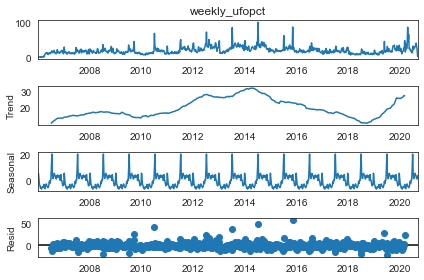

In [6]:
# weekly decompose 1: ufo percentage vals

# seasonal decomposing ufo_pct
res = sm.tsa.seasonal_decompose(wufo.weekly_ufopct)
resplot = res.plot()

### Decompose UFO total counts over time == Double Check

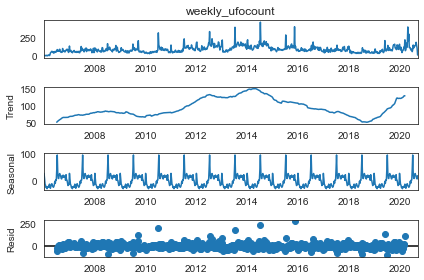

In [7]:
# weekly decompose 2: ufo count
res = sm.tsa.seasonal_decompose(wufo.weekly_ufocount)
resplot = res.plot()

# Checking for Autocorrelation

### lag plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

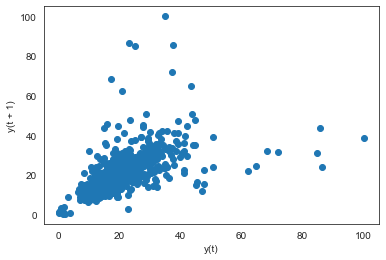

In [8]:
# see lag_plot
lag_plot(wufo.weekly_ufopct)

# A diagonal line along would shows that there is an autoregressive relationship. 

#   But plot does not look very linear. More like a weird alien.  👽 

### AR Model

In [12]:
# AR Model 

train, test = wufo.weekly_ufopct[:-40], wufo.weekly_ufopct[-40:]
model = AR(wufo.weekly_ufopct)
model_fit = model.fit(maxlag=1)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)


In [13]:
ardf = pd.DataFrame({'observed':wufo.weekly_ufopct[-40:], 'predicted':predictions})
ardf.head()

,observed,predicted
date,,
2019-12-08,19.361702,20.460077
2019-12-15,31.276596,19.597910
2019-12-22,34.680851,26.495243
2019-12-29,23.617021,28.465909
2020-01-05,17.659574,22.061243


## Stationarity
A time series is considered stationary if its mean and variance do not vary over time. While we cannot consider a stationary time series to be independent, stationarity is a dependence structure that can help us with a number of modeling techniques. To check whether we have a stationary time series, we can either examine the decomposition plot visually, compute the mean and standard deviation over time, or use statistical tests. One possible test is the Augmented Dickey-Fuller test. This test has the following hypothesis:

**H 0: The data is not stationary**

**H 1: The data is stationary** 

In [14]:
# see adfuller
adfuller(wufo.weekly_ufopct)

# The second position in the data structure returned is the p-value of our hypothesis

(-4.844478534751074,
 4.467514355802841e-05,
 7,
 758,
 {'1%': -3.439006442437876,
  '5%': -2.865360521688131,
  '10%': -2.5688044403756587},
 5238.530967412347)

#### p value



In [15]:
# p-val:
pval = adfuller(wufo.weekly_ufopct)[1]
H1_confidence = pval*100
H0_confidence = 100-H1_confidence

print("\nH1_confidence =",H1_confidence,"\nH0_confidence =",H0_confidence)
print("\n\n p-value:",pval,"\n\n We reject the null hypothesis with a confidence of",H0_confidence,"percent.\n We conclude that the data is not stationary.\n\n")



H1_confidence = 0.004467514355802841 
H0_confidence = 99.99553248564419


 p-value: 4.467514355802841e-05 

 We reject the null hypothesis with a confidence of 99.99553248564419 percent.
 We conclude that the data is not stationary.




In [16]:
# fit model
model = ARMA(wufo.weekly_ufopct, order=(2, 1))
model_fit = model.fit(disp=False)

# make prediction
predictions = model_fit.predict(len(wufo.weekly_ufopct)-40, len(wufo.weekly_ufopct)-1)

# save predictions to df
predictdf = pd.DataFrame(predictions).rename(columns={0:'prediction'})

In [20]:
# save to df ufoarma and export
ufoarma = pd.DataFrame({'observed':wufo.weekly_ufopct[-40:], 'predicted':predictions})
#ufoarma.to_csv('../Data/Datasets/nb6_ufoarma.csv')

<AxesSubplot:xlabel='month', ylabel='weekly_ufopct'>

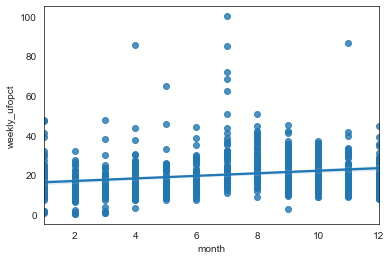

In [99]:
# see regplot for months
sns.regplot(x="month", y="weekly_ufopct", data=wufo)
